In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 13 11:59:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     40MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2022-02-13 11:59:31 +01:00)


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 0 ns (started: 2022-02-13 11:59:34 +01:00)


In [4]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Activation,Input,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

time: 3.69 s (started: 2022-02-13 11:59:38 +01:00)


In [5]:
#define directory path => adapted to my laptop
root_dir ='C:/Users/sioha/Projet_mushroom/' #project folder path
raw_data_dir = root_dir + 'RAW DATA/' #raw images folder
DL_dir = root_dir + 'Deep_learning/' #Deep Learning folder

# export dir with time stamp to save the results of the Deep Learning
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/sioha/Projet_mushroom/Deep_learning/220213_11H59/
time: 0 ns (started: 2022-02-13 11:59:46 +01:00)


In [37]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-02 17:43:11 +01:00)


LIST OF THE TOP7 FAMILIES TO KEEP FOR DEEP LEARNING
THE FAMILY IS THE CLASSIFICATION TARGET
(top7: more than 4000 images per family; up to 6119 for the top1)

In [6]:
# load final database
df_paths =  pd.read_csv(root_dir + 'image_and_json_data.csv')
print(df_paths.shape)
df_paths.head()

(215410, 38)


C:\Users\sioha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


file_name                                          file_path  resolution  \
0  1208.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...  (243, 320)   
1  1604.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...  (320, 164)   
2  1608.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...  (320, 286)   
3    29.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...  (240, 320)   
4   680.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...  (240, 320)   

   file_year  image_id format observation       label  \
0       2006      1208    jpg        1007  Agaricales   
1       2006      1604    jpg        1535  Agaricales   
2       2006      1608    jpg        1537  Agaricales   
3       2006        29    jpg          23  Agaricales   
4       2006       680    jpg         536    Agaricus   

                                     image_url user  ...  \
0  http://mushroomobserver.org/images/320/1208   25  ...   
1  http://mushroomobserver.org/images/320/1604   43  ...   
2  http://mushroomobserver.org/images/320/1608   43  ...   
3    http://mushroomobserver.org/images/320/29    1  ...   
4   http://mushroomobserver.org/images/320/680    1  ...   

  gbif_info.canonicalName  gbif_info.phylumKey gbif_info.class  \
0              Agaricales                 34.0  Agaricomycetes   
1              Agaricales                 34.0  Agaricomycetes   
2              Agaricales                 34.0  Agaricomycetes   
3              Agaricales                 34.0  Agaricomycetes   
4                Agaricus                 34.0  Agaricomycetes   

  gbif_info.synonym gbif_info.scientificName  gbif_info.genus gbif_info.order  \
0             False               Agaricales              NaN      Agaricales   
1             False               Agaricales              NaN      Agaricales   
2             False               Agaricales              NaN      Agaricales   
3             False               Agaricales              NaN      Agaricales   
4             False                 Agaricus         Agaricus      Agaricales   

  gbif_info.note  gbif_info                 json_file  
0            NaN        NaN  JSON\observations_0.json  
1            NaN        NaN  JSON\observations_0.json  
2            NaN        NaN  JSON\observations_0.json  
3            NaN        NaN  JSON\observations_0.json  
4            NaN        NaN  JSON\observations_0.json  

[5 rows x 38 columns]

time: 1.97 s (started: 2022-02-13 12:00:01 +01:00)


In [7]:
#select only (width=320,height=240) images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)']
df_paths = df_paths[df_paths['gbif_info.family'].notna()] # drop na
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90] # keep confidence level over 90 

# keep only most common class 'Agaricomycetes'
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 218 ms (started: 2022-02-13 12:00:09 +01:00)


In [8]:
# Check number of families with more than 2000 images per family
family_count=pd.DataFrame(df_paths['gbif_info.family'].value_counts())
family_count=family_count[family_count['gbif_info.family']>2000]
family_count=family_count.reset_index()
family_count=family_count.rename({'index':'family'},axis=1)
print(family_count.shape)
family_count

(11, 2)


family  gbif_info.family
0        Russulaceae              6119
1         Boletaceae              6060
2        Agaricaceae              5254
3   Tricholomataceae              4967
4        Amanitaceae              4769
5     Strophariaceae              4494
6     Cortinariaceae              4124
7       Polyporaceae              2757
8    Psathyrellaceae              2538
9     Hygrophoraceae              2526
10        Mycenaceae              2420

time: 16 ms (started: 2022-02-13 12:00:13 +01:00)


In [9]:
# keep only top7 families with more than 4000 images per family
family_number=7 #number of families to keep
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
print('top7 families_total images:',family_count.iloc[:7,-1].sum())

top7 families_total images: 35787
time: 47 ms (started: 2022-02-13 12:00:18 +01:00)


In [10]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-13 12:00:20 +01:00)


RANDOM SELECTION OF 5000 IMAGES AMONG THE TOTAL TOP7 FAMILIES OF 35787 IMAGES
in order to assess the training time of the MobileNetVS3Small
(in comparison the VGG19 model took more than 4h on 5000 images with a val_accuracy around 0.5)

In [43]:
# random selection of 5000 images 
random_seed=42 #for the random_state in the train_test_split to use the same data in the project group
df_paths,_ = train_test_split(df_paths,train_size=5000,stratify=df_paths['gbif_info.family'],
                              random_state=random_seed)
print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 62 ms (started: 2022-02-02 17:43:56 +01:00)


In [44]:
# subset col of interest + label encoding
df = df_paths[['file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(),
                                             [*range(len(df['gbif_info.family'].unique()))]) #label encoding 
df.head()

file_path gbif_info.family  \
44369   C:/Users/sioha/Projet_mushroom/IMAGES/2010\Rus...      Russulaceae   
172598  C:/Users/sioha/Projet_mushroom/IMAGES/2015\Lac...      Russulaceae   
184582  C:/Users/sioha/Projet_mushroom/IMAGES/2015\Tyl...       Boletaceae   
211179  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Rus...      Russulaceae   
63243   C:/Users/sioha/Projet_mushroom/IMAGES/2011\Psi...   Strophariaceae   

        label  
44369       0  
172598      0  
184582      1  
211179      0  
63243       2

time: 15 ms (started: 2022-02-02 17:44:00 +01:00)


In [45]:
#verification label encoding
print(df['label'].value_counts().sum())
df['label'].value_counts()

5000


0    855
1    847
5    734
3    694
4    666
2    628
6    576
Name: label, dtype: int64

time: 0 ns (started: 2022-02-02 17:44:06 +01:00)


In [46]:
# compute number of classes
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

label  gbif_info.family  size
0      0       Russulaceae   855
1      1        Boletaceae   847
2      2    Strophariaceae   628
3      3  Tricholomataceae   694
4      4       Amanitaceae   666
5      5       Agaricaceae   734
6      6    Cortinariaceae   576

time: 0 ns (started: 2022-02-02 17:44:10 +01:00)


In [47]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{0: 'Russulaceae',
 1: 'Boletaceae',
 2: 'Strophariaceae',
 3: 'Tricholomataceae',
 4: 'Amanitaceae',
 5: 'Agaricaceae',
 6: 'Cortinariaceae'}

time: 0 ns (started: 2022-02-02 17:44:15 +01:00)


In [ ]:
random_seed = 42 # for random_state in the train_test_split 
resol = (240, 320) #images dimensions (height,width)
family_number = 7 # number of family to keep
number_of_images = 5000 # None to get all images 
epochs = 10 # epoch 
learning_rate = 0.001 # a learning rate of 0.001 is often used / working
batch_size = 32 # batch size
base_model_trainable = False # base model trainable

TRAIN_TEST_SPLIT

In [48]:
random_seed=42
X_train_path,X_test_path,y_train,y_test=train_test_split(df['file_path'],df['label'],train_size=0.8,
                                                         stratify =df['label'], random_state=random_seed)
print(X_train_path.shape,X_test_path.shape)

(4000,) (1000,)
time: 0 ns (started: 2022-02-02 17:44:55 +01:00)


PLOT SOME RANDOM IMAGES PER FAMILY/CLASS
Différentes remarques:
- cela nous permet de constater qu'il n'est pas facile à l'oeil nu pour un amateur de reconnaitre les différentes famille de champignon
- il n'y pas forcément qu'une seule couleur par famille
- la forme n'est pas non plus homogène notamment à cause de l'angle de vue lors de la prise de la photo (vue du dessus, de côté, un seul ou plusieurs champignons sur la même image)
- l'environnement est aussi différent en fonction des images (dans l'herbe, dans la terre, sur une table, avec une main,etc.)

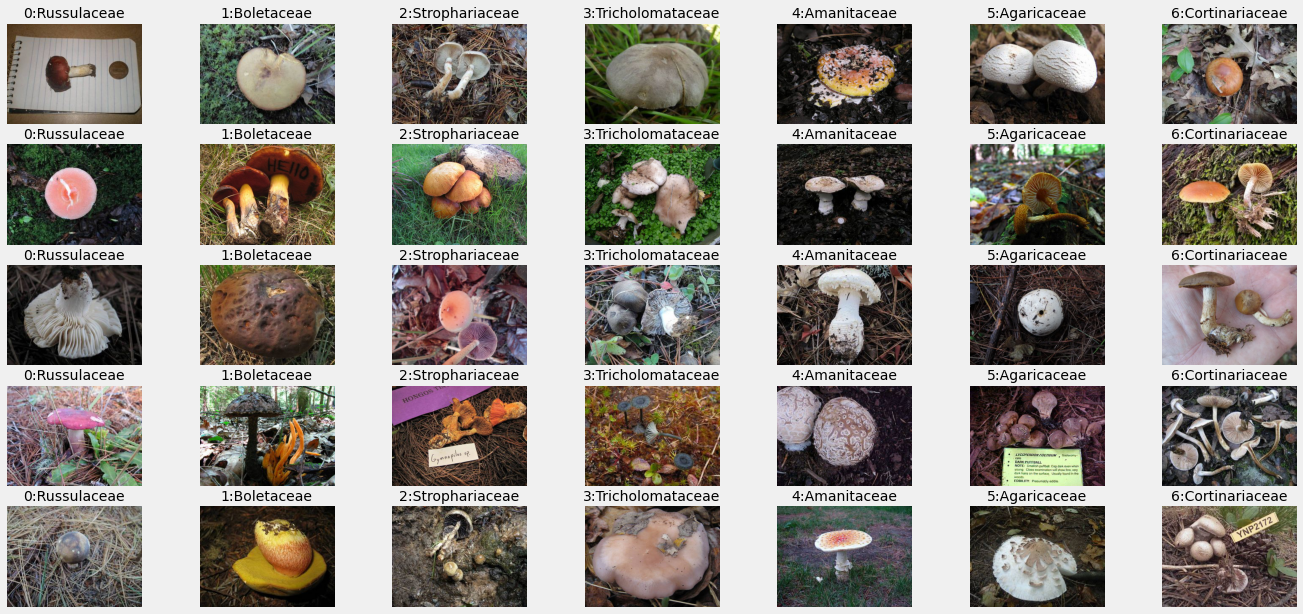

time: 6.23 s (started: 2022-02-02 17:45:06 +01:00)


In [49]:
# Plot random images de X_train (im_per_class per class)
resol=(240,320) #format (height,width) with 
im_per_class = 5 
# generate a df train from idx
train_idx = X_train_path.index
df_train = df.loc[train_idx]
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class):
    df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
    df_ = df_.droplevel(level=0)
    dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# list to catch X_train postion to plot tf dataset
im_position = []
# plot
fig=plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
    col_number = family_number
    row_number = im_per_class
    ax = plt.subplot(row_number,col_number,j)
    im = io.imread(X_train_path[idx])
    plt.imshow(im)
    label = str(y_train[idx]) + ':' + dict_label[y_train[idx]]
    im_position.append(y_train.index.get_loc(idx)) # position dans le array y_train
    plt.title(label,size = 14)
    plt.axis('off')
    j +=1
    fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

SAVE THE 5000 IMAGES IN 2 FOLDERS TRAIN & TEST
And one sub-folder per family
The goal is to use it with the ImageDataGenerator.flow_from_directory

Save the 1000 images in the folder Test

In [122]:
test_idx = X_test_path.index
image_id_test_list=[]
for i in range(len(test_idx)):
    image_id_test_list.append(df_paths['image_id'].loc[test_idx[i]])
df_test2=df_test.copy()
df_test2['image_id']=image_id_test_list
print(df_test2.shape)
df_test2.head()

(1000, 4)


file_path gbif_info.family  \
39476   C:/Users/sioha/Projet_mushroom/IMAGES/2010\Lyc...      Agaricaceae   
64357   C:/Users/sioha/Projet_mushroom/IMAGES/2011\Rus...      Russulaceae   
192134  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Cha...       Boletaceae   
133167  C:/Users/sioha/Projet_mushroom/IMAGES/2014\Chl...      Agaricaceae   
172598  C:/Users/sioha/Projet_mushroom/IMAGES/2015\Lac...      Russulaceae   

        label  image_id  
39476       5     95339  
64357       0    179314  
192134      1    634151  
133167      5    416069  
172598      0    551016

time: 31 ms (started: 2022-02-01 00:30:08 +01:00)


In [134]:
#save the 1000 images of df_test2 in the same folder "Test"
#there is one sub-folder per family
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
img_id_list=df_test2['image_id']
img_id_list=img_id_list.astype(str)
img_path_list=df_test2['file_path']
img_family_list=df_test2['gbif_info.family']

for path,img_id,img_family in tqdm(zip(img_path_list,img_id_list,img_family_list)):  
    img=Image.open(path)
    img.save(root_dir+'5000_imgs_for_DL/Test/'+img_family+'/'+img_id+'.jpg')

1000it [00:05, 196.52it/s]

time: 5.09 s (started: 2022-02-01 00:44:14 +01:00)


Save the 4000 images in the folder Train

In [138]:
train_idx = X_train_path.index
image_id_train_list=[]
for i in range(len(train_idx)):
    image_id_train_list.append(df_paths['image_id'].loc[train_idx[i]])
df_train2=df_train.copy()
df_train2['image_id']=image_id_train_list
print(df_train2.shape)
df_train2.head()

(4000, 4)


file_path  gbif_info.family  \
135576  C:/Users/sioha/Projet_mushroom/IMAGES/2014\Cor...    Cortinariaceae   
92072   C:/Users/sioha/Projet_mushroom/IMAGES/2012\Por...        Boletaceae   
122956  C:/Users/sioha/Projet_mushroom/IMAGES/2013\Rus...       Russulaceae   
102817  C:/Users/sioha/Projet_mushroom/IMAGES/2013\Bao...        Boletaceae   
156049  C:/Users/sioha/Projet_mushroom/IMAGES/2014\Tri...  Tricholomataceae   

        label  image_id  
135576      6    438583  
92072       1    238450  
122956      0    359694  
102817      1    364433  
156049      3    475648

time: 78 ms (started: 2022-02-01 00:54:34 +01:00)


In [143]:
#save the 4000 images of df_train2 in the same folder "Train"
#there is one sub-folder per family
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
img_id_list=df_train2['image_id']
img_id_list=img_id_list.astype(str)
img_path_list=df_train2['file_path']
img_family_list=df_train2['gbif_info.family']

for path,img_id,img_family in tqdm(zip(img_path_list,img_id_list,img_family_list)):  
    img=Image.open(path)
    img.save(root_dir+'5000_imgs_for_DL/Train/'+img_family+'/'+img_id+'.jpg')

4000it [00:18, 221.90it/s]

time: 18 s (started: 2022-02-01 00:56:52 +01:00)


In [50]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-02 17:45:39 +01:00)


ImageDataGenerator

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_generator=ImageDataGenerator(rotation_range=50,width_shift_range=0.2,height_shift_range=0.2,
                                        horizontal_flip=True,validation_split=0.2)
test_data_generator=ImageDataGenerator()

time: 0 ns (started: 2022-02-13 12:03:15 +01:00)


In [52]:
training_data=train_data_generator.flow_from_directory(directory=root_dir+'5000_imgs_for_DL/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=32,subset="training")
validation_data=train_data_generator.flow_from_directory(directory=root_dir+'5000_imgs_for_DL/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=32,subset="validation")
test_data=test_data_generator.flow_from_directory(directory=root_dir+'5000_imgs_for_DL/Test/',
                                                  target_size=(240,320),class_mode='sparse',
                                                  batch_size=32)

Found 3203 images belonging to 7 classes.
Found 797 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
time: 265 ms (started: 2022-02-02 17:46:01 +01:00)


AFFICHAGE DE 4 IMAGES ORIGINALES + LEURS MODIFICATIONS AVEC ImageDataGenerator

In [53]:
family_dirs = [f.path for f in os.scandir(root_dir+'5000_imgs_for_DL/Train') if f.is_dir()]
display(family_dirs)

['C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Agaricaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Amanitaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Boletaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Cortinariaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Russulaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Strophariaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Tricholomataceae']

time: 0 ns (started: 2022-02-02 17:46:39 +01:00)


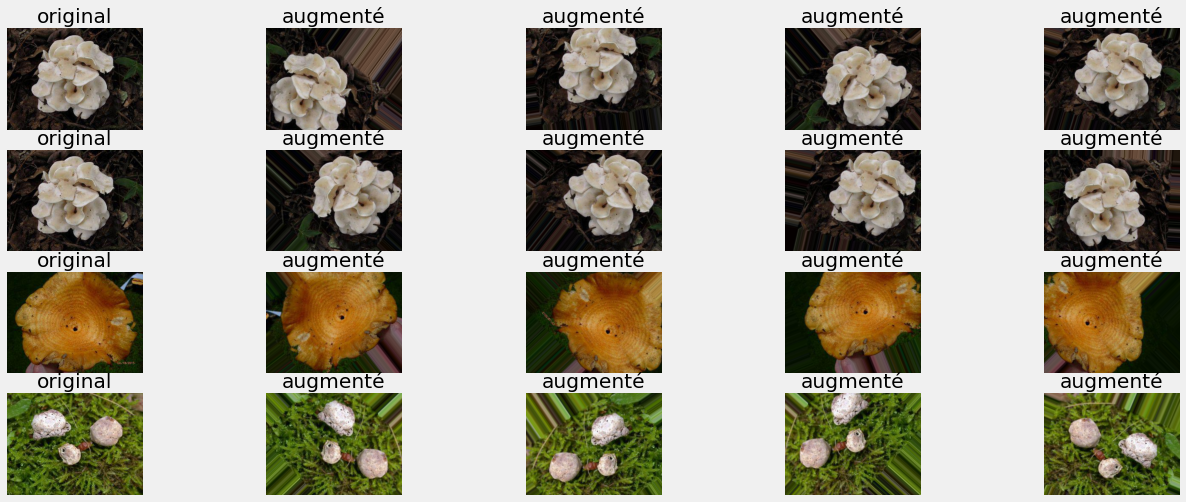

time: 1.2 s (started: 2022-02-02 17:46:45 +01:00)


In [54]:
#sélection aléatoire parmi les 1000 images de Test
fig,axs=plt.subplots(4,5,figsize=(20,8))
batch=np.random.randint(30) #last batch n°32 not included as there is only 8 images in this group
for row in range(4):
    indice=np.random.randint(31) #choix aléatoire parmi les 32 images du groupe batch
    im=np.array(test_data[batch][0][indice],dtype=np.uint8)
#    im=io.imread(df['file_path'].iloc[indice])
    axs[row,0].imshow(im)
    axs[row,0].set_title('original')
    axs[row,0].axis('off')
    for col in range(1,5):
        im_gen=train_data_generator.random_transform(im)
        axs[row,col].imshow(im_gen)
        axs[row,col].set_title('augmenté')
        axs[row,col].axis('off')

In [55]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-02 17:46:58 +01:00)


FUNCTIONS DEFINITION

Function "define_model" to create the model with a model_name and a base_model such as the VGG19

In [11]:
#Function "plot_history"
def plot_history(model_history):
    train_acc_model = model_history.history['accuracy']
    val_acc_model = model_history.history['val_accuracy']  

    fig = plt.figure(figsize=(20,5))
    plt.subplot(121) #loss & val_loss results versus epochs
    plt.plot(range(len(model_history.history['loss'])), model_history.history['loss'],
             '-o', label = "training")
    plt.plot(range(len(model_history.history['val_loss'])), model_history.history['val_loss'],
             '-o',label = "validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss versus epoch")
    plt.legend()

    plt.subplot(122) #accuracy & val_accuracy versus epochs
    plt.plot(range(len(model_history.history['accuracy'])), model_history.history['accuracy'],
             '-o', label = "training")
    plt.plot(range(len(model_history.history['val_accuracy'])), model_history.history['val_accuracy'],
             '-o',label = "validation")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy versus epoch")
    plt.legend();
    fig.suptitle(pathinfos + '_training history',size = 20)
    fig.subplots_adjust(top=0.8)
    plt.close()
    return fig

time: 0 ns (started: 2022-02-13 12:00:38 +01:00)


In [12]:
#Function to plot a colored confusion matrix
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
    cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

    classes = range(0,(classes))
    fig = plt.figure(figsize=(15,5))
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j],'.1f'),horizontalalignment = "center",
            color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels (%)')
    plt.xlabel('Labels prédits (%)')

    #add label dict 
    lab_dict = 'label, family, count  \n\n '
    lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
    lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
    lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
    plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
    #TITLE 
    title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
    plt.title(title, size=18,y=1.12,x=1)

    # plt.show()
    plt.close()
    return fig

time: 0 ns (started: 2022-02-13 12:00:41 +01:00)


In [13]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-13 12:00:44 +01:00)


CALLBACKS

In [14]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min',restore_best_weights=True)
lr_plateau=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,verbose=2,mode='min',
                                       min_lr=1e-10)

time: 0 ns (started: 2022-02-13 12:00:56 +01:00)


In [61]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-02 17:48:22 +01:00)


MODEL MobileNetV3Small+classification

In [65]:
from tensorflow.keras.applications import MobileNetV3Small
base_model=MobileNetV3Small(weights='imagenet',include_top=False)
for layer in base_model.layers: #freeze the base_model layers
    layer.trainable = False
model3=Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D()) 
model3.add(Dense(units = 1024, activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(units = 512, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(units = 7, activation = 'softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [67]:
#Model.fit
from tensorflow.keras.optimizers import Adam
start = time.time()
model3.compile(optimizer=Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
training3_history=model3.fit(training_data,validation_data=validation_data,epochs=10,
                             steps_per_epoch=3203//32,validation_steps=797//32,
                             callbacks=[early_stopping,lr_plateau])
end = time.time() 
total_time = end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

Epoch 1/10
100/100 [==============================] - 100s 985ms/step - loss: 1.2712 - accuracy: 0.5386 - val_loss: 1.5439 - val_accuracy: 0.4479 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 100s 1s/step - loss: 1.1666 - accuracy: 0.5837 - val_loss: 1.4148 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - 104s 1s/step - loss: 1.0590 - accuracy: 0.6149 - val_loss: 1.4975 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 106s 1s/step - loss: 0.9547 - accuracy: 0.6462 - val_loss: 1.4739 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.9008 - accuracy: 0.6742
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 [==============================] - 105s 1s/step - loss: 0.9008 - accuracy: 0.6742 - val_loss: 1.4337 - val_accuracy: 0.5013 - lr: 0.0010
il faut 8.615min pour construire le model
time: 8min

In [68]:
# export dir with time stamp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/sioha/Projet_mushroom/Deep_learning/220202_18H14/
time: 0 ns (started: 2022-02-02 18:14:43 +01:00)


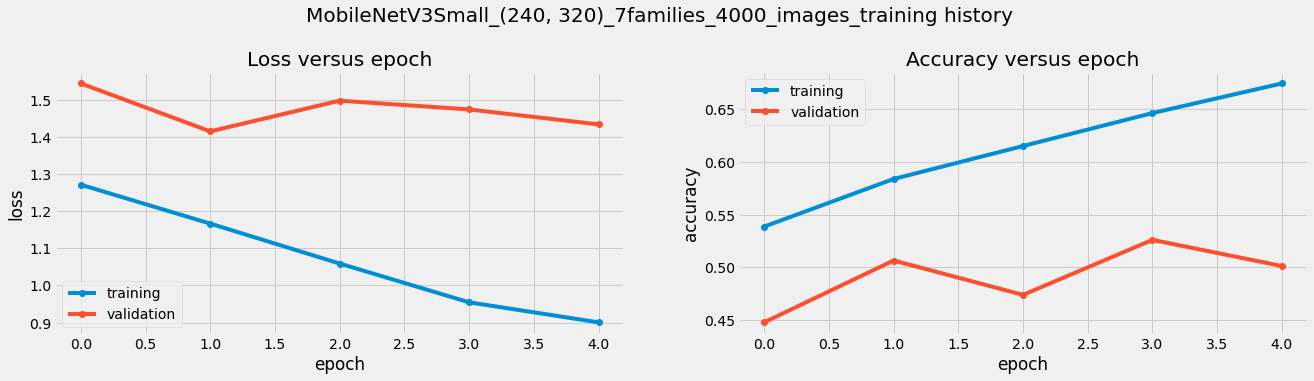

time: 422 ms (started: 2022-02-02 18:15:11 +01:00)


In [69]:
# save history 
pathinfos = 'MobileNetV3Small_(240, 320)_7families_4000_images'
hist_df3 = pd.DataFrame(training3_history.history)
hist_df3.to_csv(export_dir + pathinfos + '_history.csv')
training3_history_fig = plot_history(training3_history)
display(training3_history_fig)
# save fig 
training3_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg' )

In [70]:
#predict class 
start=time.time()
test_pred_class=[]
for i in range(32):
    test_pred_class_temp = model3.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
end=time.time()
print('durée totale calcul :',end-start)

durée totale calcul : 17.56498908996582
time: 17.6 s (started: 2022-02-02 18:16:04 +01:00)


test_data[i][0]: group of images by batch of 32 images with i from 0 to 30 and only 8 images for i=31
Reason: total of 1000 images splitted by groups of 32 images => 31*32+8=1000
test_data[i][1]: label or family class of the group i

In [71]:
#assess performances
y_test_class=[]
for i in range(32):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.59      0.47      0.52       147
         1.0       0.50      0.62      0.56       133
         2.0       0.77      0.61      0.68       169
         3.0       0.36      0.44      0.40       115
         4.0       0.60      0.48      0.53       171
         5.0       0.53      0.54      0.53       126
         6.0       0.43      0.55      0.48       139

    accuracy                           0.53      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.55      0.53      0.54      1000

time: 1.67 s (started: 2022-02-02 18:16:34 +01:00)


In [72]:
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

time: 16 ms (started: 2022-02-02 18:16:54 +01:00)


In [73]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(test_data.class_indices,index=['label']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'gbif_info.family'},axis=1)
test_dict_label

gbif_info.family  label  y_test_count
0       Agaricaceae      0           147
1       Amanitaceae      1           133
2        Boletaceae      2           169
3    Cortinariaceae      3           115
4       Russulaceae      4           171
5    Strophariaceae      5           126
6  Tricholomataceae      6           139

time: 15 ms (started: 2022-02-02 18:16:57 +01:00)


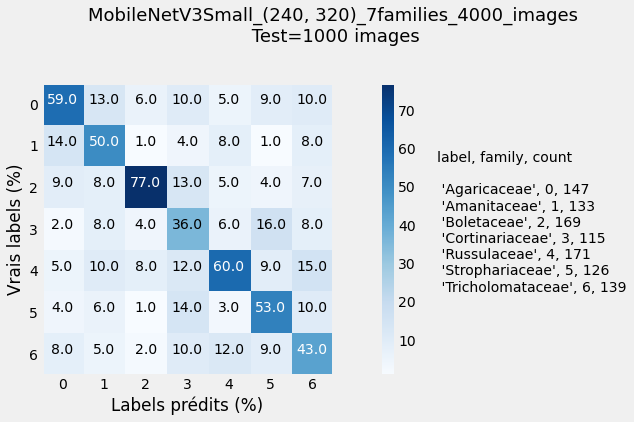

durée calcul[min]: 1616425189.3124764
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
time: 562 ms (started: 2022-02-02 18:17:04 +01:00)


In [74]:
# colored conf matrix  
classes = test_dict_label['gbif_info.family'].nunique()  # classes
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
end=time.time()
print('durée calcul[min]:',end-start//60)
print('*'*115)
print('*'*115)
print('*'*115)
print('*'*115)

MOBILENETV3SMALL ON THE COMPLETE TOP7 FAMILIES (35787 images)
Reasons:
- best compromise between execution time and performances (loss and accuracy) => from Sebastien's results
- comparison between 5000 images versus 35787 images

Conclusion: important improvement of the results with more images
batch_size = 32 images in the model
- f1_score=0.53 on the 1000 images of Test (model trained on 4000 images + validated on 1000 images)
- f1_score=0.62 on the 7158 images of Test (model trained on 28629 images + validated on 7158 images)

In [15]:
df_paths =  pd.read_csv(root_dir + 'image_and_json_data.csv')
#select only (width=320,height=240) images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)']
df_paths = df_paths[df_paths['gbif_info.family'].notna()] # drop na
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90] # keep conf level over 90 

# keep only most common class 'Agaricomycetes'
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

# keep only top7 families with more than 4000 images per family
family_number=7 #number of families to keep
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
df_paths

C:\Users\sioha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


file_name                                          file_path  \
5          682.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...   
6          685.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...   
7          710.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...   
8          707.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...   
9          708.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...   
...            ...                                                ...   
214961  651227.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Xer...   
214962  652314.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Xer...   
214964  654236.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Xer...   
214968  626675.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Xer...   
214980  696016.jpg  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Xer...   

        resolution  file_year  image_id format  \
5       (320, 240)       2006       682    jpg   
6       (320, 240)       2006       685    jpg   
7       (320, 240)       2006       710    jpg   
8       (320, 240)       2006       707    jpg   
9       (320, 240)       2006       708    jpg   
...            ...        ...       ...    ...   
214961  (320, 240)       2016    651227    jpg   
214962  (320, 240)       2016    652314    jpg   
214964  (320, 240)       2016    654236    jpg   
214968  (320, 240)       2016    626675    jpg   
214980  (320, 240)       2016    696016    jpg   

                              observation                    label  \
5                                     537                 Agaricus   
6                                     538                 Agaricus   
7                                     557   Agaricus albolutescens   
8                                     555        Agaricus augustus   
9                                     556        Agaricus augustus   
...                                   ...                      ...   
214961                             249357       Xerocomus illudens   
214962                             249712       Xerocomus illudens   
214964                             250279       Xerocomus illudens   
214968                             241788       Xerocomus parvulus   
214980  /observer/show_observation/263816  Xerocomus subtomentosus   

                                            image_url  \
5          http://mushroomobserver.org/images/320/682   
6          http://mushroomobserver.org/images/320/685   
7          http://mushroomobserver.org/images/320/710   
8          http://mushroomobserver.org/images/320/707   
9          http://mushroomobserver.org/images/320/708   
...                                               ...   
214961  http://mushroomobserver.org/images/320/651227   
214962  http://mushroomobserver.org/images/320/652314   
214964  http://mushroomobserver.org/images/320/654236   
214968  http://mushroomobserver.org/images/320/626675   
214980  http://mushroomobserver.org/images/320/696016   

                            user  ...  gbif_info.canonicalName  \
5                              1  ...                 Agaricus   
6                              1  ...                 Agaricus   
7                              1  ...   Agaricus albolutescens   
8                              1  ...        Agaricus augustus   
9                              1  ...        Agaricus augustus   
...                          ...  ...                      ...   
214961                       667  ...       Xerocomus illudens   
214962                      1909  ...       Xerocomus illudens   
214964                      1909  ...       Xerocomus illudens   
214968                      7286  ...       Xerocomus parvulus   
214980  /observer/show_user/9652  ...  Xerocomus subtomentosus   

        gbif_info.phylumKey gbif_info.class gbif_info.synonym  \
5                      34.0  Agaricomycetes             False   
6                      34.0  Agaricomycetes             False   
7                

time: 2.2 s (started: 2022-02-13 12:01:21 +01:00)


In [16]:
# subset col of interest + label encoding
df_top7 = df_paths[['file_path','image_id','gbif_info.family']].copy()
df_top7['label'] = df_top7['gbif_info.family'].replace(df_top7['gbif_info.family'].unique(),
                                             [*range(len(df_top7['gbif_info.family'].unique()))]) 
df_top7.head()

file_path  image_id  \
5  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...       682   
6  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...       685   
7  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...       710   
8  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...       707   
9  C:/Users/sioha/Projet_mushroom/IMAGES/2006\Aga...       708   

  gbif_info.family  label  
5      Agaricaceae      0  
6      Agaricaceae      0  
7      Agaricaceae      0  
8      Agaricaceae      0  
9      Agaricaceae      0

time: 47 ms (started: 2022-02-13 12:01:28 +01:00)


In [17]:
#check label encoding
print(df_top7['label'].value_counts().sum())
df_top7['label'].value_counts()

35787


6    6119
3    6060
0    5254
4    4967
2    4769
1    4494
5    4124
Name: label, dtype: int64

time: 16 ms (started: 2022-02-13 12:01:31 +01:00)


In [78]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-02 18:17:43 +01:00)


TRAIN_TEST_SPLIT

In [79]:
random_seed=42
X_train_path,X_test_path,y_train,y_test=train_test_split(df_top7['file_path'],df_top7['label'],
                                                         train_size=0.8,stratify =df_top7['label'],
                                                         random_state=random_seed)
print(X_train_path.shape,X_test_path.shape)

(28629,) (7158,)
time: 16 ms (started: 2022-02-02 18:17:56 +01:00)


SAVE THE 35787 IMAGES (all top7 families) IN 2 FOLDERS TRAIN & TEST
And one sub-folder per family
The goal is to use it with the ImageDataGenerator.flow_from_directory

Save the 7158 images of X_test

In [80]:
test_idx = X_test_path.index
df_top7_test = df_top7.loc[test_idx]
print(df_top7_test.shape)
df_top7_test.head()

(7158, 4)


file_path  image_id  \
26647   C:/Users/sioha/Projet_mushroom/IMAGES/2009\Tri...     54250   
37124   C:/Users/sioha/Projet_mushroom/IMAGES/2010\Inf...    119363   
197994  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Gym...    643211   
25223   C:/Users/sioha/Projet_mushroom/IMAGES/2009\Rus...     46954   
103277  C:/Users/sioha/Projet_mushroom/IMAGES/2013\Bol...    361567   

        gbif_info.family  label  
26647   Tricholomataceae      4  
37124   Tricholomataceae      4  
197994    Strophariaceae      1  
25223        Russulaceae      6  
103277        Boletaceae      3

time: 16 ms (started: 2022-02-02 18:18:11 +01:00)


In [318]:
#save the 7158 images of df_top7_test in the same folder "Test"
#there is one sub-folder per family
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
img_id_list=df_top7_test['image_id']
img_id_list=img_id_list.astype(str)
img_path_list=df_top7_test['file_path']
img_family_list=df_top7_test['gbif_info.family']

for path,img_id,img_family in tqdm(zip(img_path_list,img_id_list,img_family_list)):  
    img=Image.open(path)
    img.save(root_dir+'Top7families_imgs/Test/'+img_family+'/'+img_id+'.jpg')

7158it [00:56, 127.23it/s]

time: 56.3 s (started: 2022-02-01 22:57:14 +01:00)


Save the 28629 images of X_train

In [319]:
train_idx = X_train_path.index
df_top7_train = df_top7.loc[train_idx]
print(df_top7_train.shape)
df_top7_train.head()

(28629, 4)


file_path  image_id  \
9168    C:/Users/sioha/Projet_mushroom/IMAGES/2008\Hyp...     18095   
1259    C:/Users/sioha/Projet_mushroom/IMAGES/2006\Tri...        44   
214927  C:/Users/sioha/Projet_mushroom/IMAGES/2016\Xer...    632521   
135161  C:/Users/sioha/Projet_mushroom/IMAGES/2014\Cor...    460431   
153742  C:/Users/sioha/Projet_mushroom/IMAGES/2014\Rus...    482045   

        gbif_info.family  label  
9168      Strophariaceae      1  
1259    Tricholomataceae      4  
214927        Boletaceae      3  
135161    Cortinariaceae      5  
153742       Russulaceae      6

time: 16 ms (started: 2022-02-01 23:00:01 +01:00)


In [320]:
#save the 28629 images of df_top7_test in the same folder "Train"
#there is one sub-folder per family
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
img_id_list=df_top7_train['image_id']
img_id_list=img_id_list.astype(str)
img_path_list=df_top7_train['file_path']
img_family_list=df_top7_train['gbif_info.family']

for path,img_id,img_family in tqdm(zip(img_path_list,img_id_list,img_family_list)):  
    img=Image.open(path)
    img.save(root_dir+'Top7families_imgs/Train/'+img_family+'/'+img_id+'.jpg')

28629it [03:27, 137.96it/s]

time: 3min 27s (started: 2022-02-01 23:01:12 +01:00)


In [29]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-02 17:18:05 +01:00)


ImageDataGenerator

In [20]:
training_data=train_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=32,subset="training")
validation_data=train_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=32,subset="validation")
test_data=test_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Test/',
                                                  target_size=(240,320),class_mode='sparse',
                                                  batch_size=32)

Found 22905 images belonging to 7 classes.
Found 5722 images belonging to 7 classes.
Found 7156 images belonging to 7 classes.
time: 2.24 s (started: 2022-02-13 12:03:34 +01:00)


In [21]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-13 12:03:44 +01:00)


MODEL MobileNetV3Small+classification sur Top7families

In [22]:
from tensorflow.keras.applications import MobileNetV3Small
base_model=MobileNetV3Small(weights='imagenet',include_top=False)
for layer in base_model.layers: #freeze the base_model layers
    layer.trainable = False
model4=Sequential()
model4.add(base_model)
model4.add(GlobalAveragePooling2D()) 
model4.add(Dense(units = 1024, activation = 'relu'))
model4.add(Dropout(0.3))
model4.add(Dense(units = 512, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(units = 7, activation = 'softmax'))
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [24]:
from tensorflow.keras.optimizers import Adam
model4.compile(optimizer=Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

time: 15 ms (started: 2022-02-13 12:05:13 +01:00)


In [107]:
#Model.fit
start = time.time()
training4_history=model4.fit(training_data,validation_data=validation_data,epochs=20,
                             steps_per_epoch=22905//32,
                             validation_steps=5722//32,callbacks=[early_stopping,lr_plateau])
end = time.time() # timer end 
total_time=end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

Epoch 1/20
715/715 [==============================] - 803s 1s/step - loss: 1.4181 - accuracy: 0.4751 - val_loss: 1.2804 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 2/20
715/715 [==============================] - 729s 1s/step - loss: 1.2323 - accuracy: 0.5504 - val_loss: 1.2378 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 3/20
715/715 [==============================] - 753s 1s/step - loss: 1.1704 - accuracy: 0.5761 - val_loss: 1.2047 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 4/20
715/715 [==============================] - 760s 1s/step - loss: 1.1241 - accuracy: 0.5960 - val_loss: 1.1905 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 5/20
715/715 [==============================] - 760s 1s/step - loss: 1.0775 - accuracy: 0.6100 - val_loss: 1.1789 - val_accuracy: 0.5713 - lr: 0.0010
Epoch 6/20
715/715 [==============================] - 763s 1s/step - loss: 1.0518 - accuracy: 0.6253 - val_loss: 1.1810 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 7/20
715/715 [==============================] - 764s 1s/st

In [108]:
# export dir with time stamp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/sioha/Projet_mushroom/Deep_learning/220203_12H46/
time: 15 ms (started: 2022-02-03 12:46:37 +01:00)


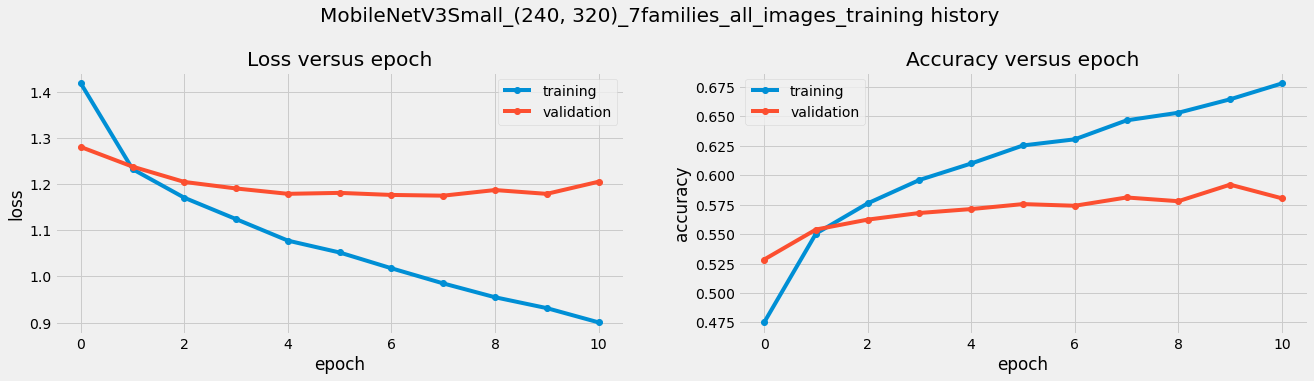

time: 344 ms (started: 2022-02-03 12:46:48 +01:00)


In [109]:
# save history 
pathinfos = 'MobileNetV3Small_(240, 320)_7families_all_images'
hist_df4 = pd.DataFrame(training4_history.history)
hist_df4.to_csv(export_dir + pathinfos + '_history.csv')
training4_history_fig = plot_history(training4_history)
display(training4_history_fig)
# save fig 
training4_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg' )

In [110]:
#assess performances 
start=time.time()
test_pred_class=[]
for i in range(224):
    test_pred_class_temp = model4.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
total_time=time.time()
print('durée totale calcul :',total_time)

durée totale calcul : 1643888950.3156888
time: 2min 7s (started: 2022-02-03 12:47:02 +01:00)


In [111]:
#confusion matrix
y_test_class=[]
for i in range(224):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.68      0.53      0.60      1049
         1.0       0.57      0.76      0.65       954
         2.0       0.76      0.71      0.74      1212
         3.0       0.55      0.48      0.51       825
         4.0       0.57      0.65      0.61      1224
         5.0       0.61      0.53      0.57       899
         6.0       0.52      0.53      0.53       993

    accuracy                           0.61      7156
   macro avg       0.61      0.60      0.60      7156
weighted avg       0.62      0.61      0.61      7156

time: 11.3 s (started: 2022-02-03 12:49:52 +01:00)


In [112]:
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

time: 15 ms (started: 2022-02-03 12:50:11 +01:00)


In [113]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(test_data.class_indices,index=['label']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'gbif_info.family'},axis=1)
test_dict_label

gbif_info.family  label  y_test_count
0       Agaricaceae      0          1049
1       Amanitaceae      1           954
2        Boletaceae      2          1212
3    Cortinariaceae      3           825
4       Russulaceae      4          1224
5    Strophariaceae      5           899
6  Tricholomataceae      6           993

time: 16 ms (started: 2022-02-03 12:50:15 +01:00)


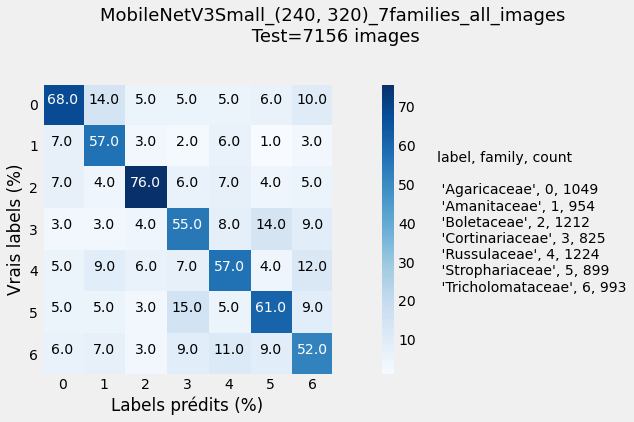

*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
time: 563 ms (started: 2022-02-03 12:50:18 +01:00)


In [114]:
# colored conf matrix  
classes = test_dict_label['gbif_info.family'].nunique()  # classes
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
print('*'*115)
print('*'*115)
print('*'*115)
print('*'*115)

MOBILENETV3SMALL ON THE COMPLETE TOP7 FAMILIES (35787 images)
Reasons:
- best compromise between execution time and performances (loss and accuracy) => from Sebastien's results
- comparison between batch_size=32 versus batch_size=100 images

Conclusion: results slightly better with the batch_size=100.
Models 4,5 &6  trained on 22905 images + validated on 5722 images and prediction done on 7156 images
- f1_score=0.61 on the 7156 images of Test with batch_size=32
- f1_score=0.61 on the 7156 images of Test with batch_size=100
- f1_score=0.60 on the 7156 images of Test with batch_size=128

In [115]:
training_data=train_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=128,subset="training")
validation_data=train_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=128,subset="validation")
test_data=test_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Test/',
                                                  target_size=(240,320),class_mode='sparse',
                                                  batch_size=128)

Found 22905 images belonging to 7 classes.
Found 5722 images belonging to 7 classes.
Found 7156 images belonging to 7 classes.
time: 1.62 s (started: 2022-02-03 12:51:26 +01:00)


In [116]:
from tensorflow.keras.applications import MobileNetV3Small
base_model=MobileNetV3Small(weights='imagenet',include_top=False)
for layer in base_model.layers: #freeze the base_model layers
    layer.trainable = False
model6=Sequential()
model6.add(base_model)
model6.add(GlobalAveragePooling2D()) 
model6.add(Dense(units = 1024, activation = 'relu'))
model6.add(Dropout(0.3))
model6.add(Dense(units = 512, activation = 'relu'))
model6.add(Dropout(0.5))
model6.add(Dense(units = 7, activation = 'softmax'))
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_12  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dropout_11 (Dropout)        (None, 512)              

In [117]:
model6.compile(optimizer=Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

time: 16 ms (started: 2022-02-03 12:52:11 +01:00)


In [118]:
start = time.time()
training6_history=model6.fit(training_data,validation_data=validation_data,epochs=20,
                             steps_per_epoch=22905//128,
                             validation_steps=5722//128,callbacks=[early_stopping,lr_plateau])
end = time.time()
total_time = end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

Epoch 1/20
178/178 [==============================] - 713s 4s/step - loss: 1.4202 - accuracy: 0.4740 - val_loss: 1.2679 - val_accuracy: 0.5369 - lr: 0.0010
Epoch 2/20
178/178 [==============================] - 724s 4s/step - loss: 1.2192 - accuracy: 0.5537 - val_loss: 1.2072 - val_accuracy: 0.5627 - lr: 0.0010
Epoch 3/20
178/178 [==============================] - 725s 4s/step - loss: 1.1439 - accuracy: 0.5858 - val_loss: 1.1823 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 4/20
178/178 [==============================] - 844s 5s/step - loss: 1.0858 - accuracy: 0.6078 - val_loss: 1.1675 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 5/20
178/178 [==============================] - 717s 4s/step - loss: 1.0387 - accuracy: 0.6226 - val_loss: 1.1624 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 6/20
178/178 [==============================] - 715s 4s/step - loss: 0.9930 - accuracy: 0.6376 - val_loss: 1.1737 - val_accuracy: 0.5826 - lr: 0.0010
Epoch 7/20
178/178 [==============================] - 717s 4s/st

In [119]:
# export dir with time stamp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/sioha/Projet_mushroom/Deep_learning/220203_15H13/
time: 16 ms (started: 2022-02-03 15:13:50 +01:00)


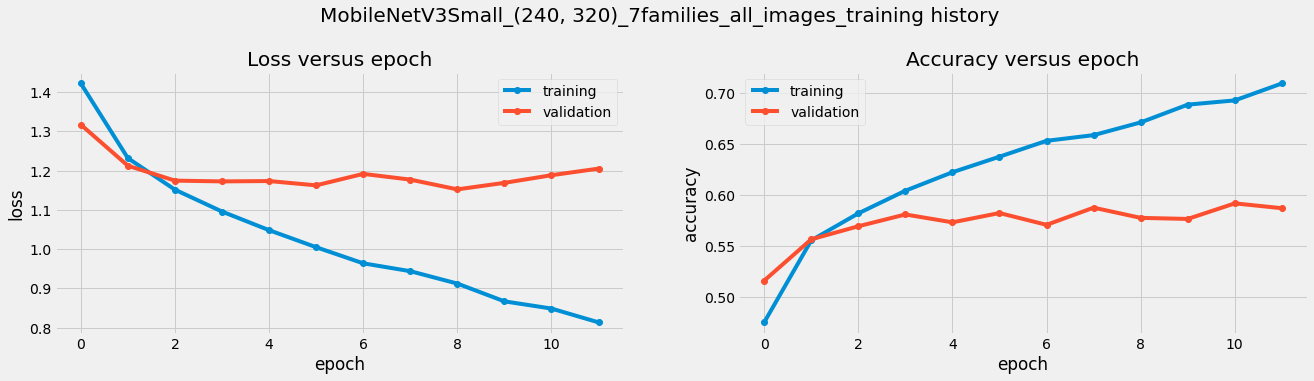

time: 313 ms (started: 2022-02-03 15:15:19 +01:00)


In [121]:
# save history 
pathinfos = 'MobileNetV3Small_(240, 320)_7families_all_images'
hist_df6 = pd.DataFrame(training6_history.history)
hist_df6.to_csv(export_dir + pathinfos + '_history.csv')
training6_history_fig = plot_history(training5_history)
display(training6_history_fig)
# save fig 
training6_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg' )

In [126]:
#assess performances 
start=time.time()
test_pred_class=[]
for i in range(56):
    test_pred_class_temp = model6.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
end=time.time()
total_time=end-start
print('durée totale calcul :',total_time)

durée totale calcul : 94.30129146575928
time: 1min 34s (started: 2022-02-03 15:19:58 +01:00)


In [127]:
#confusion matrix
y_test_class=[]
for i in range(56):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59      1049
         1.0       0.58      0.77      0.66       954
         2.0       0.73      0.74      0.73      1212
         3.0       0.57      0.43      0.49       825
         4.0       0.51      0.73      0.60      1224
         5.0       0.63      0.48      0.55       899
         6.0       0.53      0.43      0.47       993

    accuracy                           0.60      7156
   macro avg       0.61      0.59      0.59      7156
weighted avg       0.61      0.60      0.59      7156

time: 11.2 s (started: 2022-02-03 15:22:48 +01:00)


In [128]:
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

time: 15 ms (started: 2022-02-03 15:23:07 +01:00)


In [129]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(test_data.class_indices,index=['label']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'gbif_info.family'},axis=1)
test_dict_label

gbif_info.family  label  y_test_count
0       Agaricaceae      0          1049
1       Amanitaceae      1           954
2        Boletaceae      2          1212
3    Cortinariaceae      3           825
4       Russulaceae      4          1224
5    Strophariaceae      5           899
6  Tricholomataceae      6           993

time: 0 ns (started: 2022-02-03 15:23:10 +01:00)


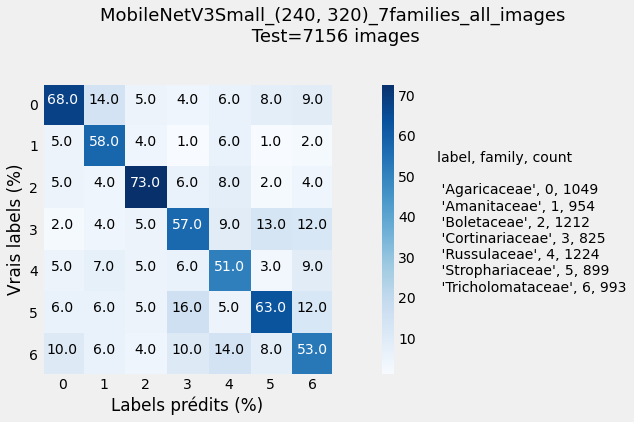

*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
time: 562 ms (started: 2022-02-03 15:23:14 +01:00)


In [130]:
#colored conf matrix  
classes = test_dict_label['gbif_info.family'].nunique()  # classes
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
print('*'*115)
print('*'*115)
print('*'*115)
print('*'*115)

COMPARISON 3 CONFIGURATIONS OF MobileNetV3Small

In [131]:
report_path3 = root_dir +'Deep_learning/220202_18H14_model3/MobileNetV3Small_(240, 320)_7families_4000_images_classification report.csv'
report_path4 = root_dir +'Deep_learning/220203_12H46_model4/MobileNetV3Small_(240, 320)_7families_all_images_classification report.csv'
report_path5 = root_dir +'Deep_learning/220203_10H01_model5/MobileNetV3Small_(240, 320)_7families_all_images_classification report.csv'
report_path6 = root_dir +'Deep_learning/220203_15H13_model6/MobileNetV3Small_(240, 320)_7families_all_images_classification report.csv'
report_model3=pd.read_csv(report_path3)
report_model4=pd.read_csv(report_path4)
report_model5=pd.read_csv(report_path5)
report_model6=pd.read_csv(report_path6)

time: 0 ns (started: 2022-02-03 15:28:46 +01:00)


In [132]:
report_model3

Unnamed: 0  precision    recall  f1-score   support
0           0.0   0.589744  0.469388  0.522727   147.000
1           1.0   0.503030  0.624060  0.557047   133.000
2           2.0   0.768657  0.609467  0.679868   169.000
3           3.0   0.361702  0.443478  0.398438   115.000
4           4.0   0.602941  0.479532  0.534202   171.000
5           5.0   0.527132  0.539683  0.533333   126.000
6           6.0   0.426966  0.546763  0.479495   139.000
7      accuracy   0.532000  0.532000  0.532000     0.532
8     macro avg   0.540025  0.530339  0.529301  1000.000
9  weighted avg   0.553964  0.532000  0.536845  1000.000

time: 0 ns (started: 2022-02-03 15:28:54 +01:00)


In [137]:
f1_score_model3=pd.DataFrame(report_model3['f1-score'].iloc[0:7])
f1_score_model3=f1_score_model3.rename({'f1-score':'model3'},axis=1)
f1_score_model4=pd.DataFrame(report_model4['f1-score'].iloc[0:7])
f1_score_model4=f1_score_model4.rename({'f1-score':'model4'},axis=1)
f1_score_model5=pd.DataFrame(report_model5['f1-score'].iloc[0:7])
f1_score_model5=f1_score_model5.rename({'f1-score':'model5'},axis=1)
f1_score_model6=pd.DataFrame(report_model6['f1-score'].iloc[0:7])
f1_score_model6=f1_score_model6.rename({'f1-score':'model6'},axis=1)
f1_score=pd.concat([f1_score_model3,f1_score_model4,f1_score_model5,f1_score_model6],axis=1)
f1_score

model3    model4    model5    model6
0  0.522727  0.597333  0.624416  0.586898
1  0.557047  0.650224  0.684389  0.662461
2  0.679868  0.737963  0.731605  0.734611
3  0.398438  0.513809  0.473755  0.494134
4  0.534202  0.610157  0.614675  0.604573
5  0.533333  0.570410  0.569149  0.546144
6  0.479495  0.528736  0.509964  0.474273

time: 15 ms (started: 2022-02-03 15:37:42 +01:00)


model3=5000imgs_batch_size_32 ; model4=35787imgs_batch_size_32 ; 
model5=35787imgs_batch_size_100 ; model6=35787imgs_batch_size_128


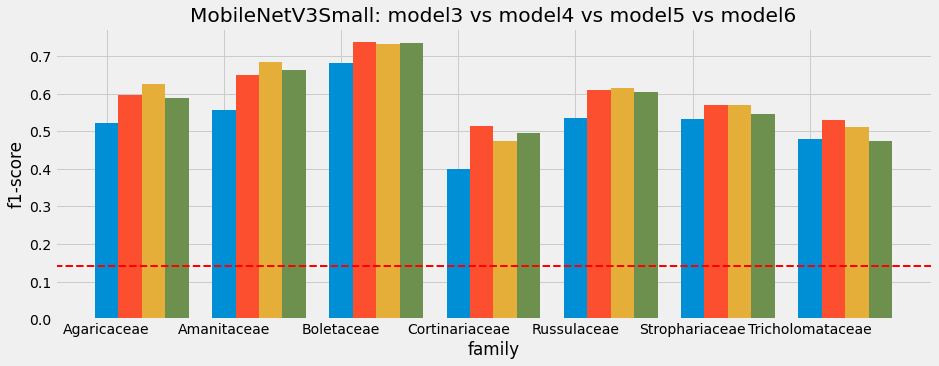

time: 157 ms (started: 2022-02-03 15:37:46 +01:00)


In [138]:
#comparison f1-score with the MobileNetV3Small
family_names=test_dict_label['gbif_info.family']
barWidth = 0.2
r = range(7)
r1= [x + barWidth for x in r]
r2= [x + 2*barWidth for x in r]
r3= [x + 3*barWidth for x in r]
plt.figure(figsize=(14,5))
plt.bar(r,f1_score.model3,width=barWidth,label='model3')
plt.bar(r1,f1_score.model4,width=barWidth,label='model4')
plt.bar(r2,f1_score.model5,width=barWidth,label='model5')
plt.bar(r3,f1_score.model6,width=barWidth,label='model6')
plt.axhline(1/7,color='red',linestyle='--',linewidth=2)
plt.xticks(r,family_names)
plt.xlabel('family')
plt.ylabel('f1-score')
plt.title('MobileNetV3Small: model3 vs model4 vs model5 vs model6');
print('model3=5000imgs_batch_size_32 ; model4=35787imgs_batch_size_32 ; \nmodel5=35787imgs_batch_size_100 ; model6=35787imgs_batch_size_128')

In [147]:
f1_score_acc_model3=pd.DataFrame(report_model3['f1-score'].iloc[7:8])
f1_score_acc_model4=pd.DataFrame(report_model4['f1-score'].iloc[7:8])
f1_score_acc_model5=pd.DataFrame(report_model5['f1-score'].iloc[7:8])
f1_score_acc_model6=pd.DataFrame(report_model6['f1-score'].iloc[7:8])
f1_score_acc=pd.concat([f1_score_acc_model3,f1_score_acc_model4,f1_score_acc_model5,
                        f1_score_acc_model6],axis=0)
f1_score_acc['model']=['model3','model4','model5','model6']
f1_score_acc=f1_score_acc.reset_index()
f1_score_acc=f1_score_acc.drop('index',axis=1)
f1_score_acc

f1-score   model
0  0.532000  model3
1  0.609139  model4
2  0.610676  model5
3  0.599637  model6

time: 16 ms (started: 2022-02-03 15:47:07 +01:00)


In [148]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-03 15:51:47 +01:00)


Save the predictions of the model6

In [149]:
test_pred_class=pd.DataFrame(test_pred_class)
test_pred_class=test_pred_class.rename({0:'pred_class'},axis=1)
test_pred_class

pred_class
0            3.0
1            1.0
2            2.0
3            1.0
4            1.0
...          ...
7151         1.0
7152         3.0
7153         3.0
7154         2.0
7155         4.0

[7156 rows x 1 columns]

time: 16 ms (started: 2022-02-03 15:52:41 +01:00)


In [150]:
y_test_class_df=y_test_class_df.rename({0:'real_class'},axis=1)
y_test_class_df

real_class
0            4.0
1            0.0
2            2.0
3            1.0
4            1.0
...          ...
7151         1.0
7152         2.0
7153         3.0
7154         2.0
7155         5.0

[7156 rows x 1 columns]

time: 15 ms (started: 2022-02-03 15:52:47 +01:00)


In [151]:
#save y_test_class_df & test_pred_class into 2 csv files
test_pred_class_path = root_dir +'Deep_learning/220203_15H13_model6/MobileNetV3Small_(240, 320)_7families_all_images_test_pred_class.csv'
test_pred_class.to_csv(test_pred_class_path)
y_test_class_path = root_dir +'Deep_learning/220203_15H13_model6/MobileNetV3Small_(240, 320)_7families_all_images_y_test_class.csv'
y_test_class_df.to_csv(y_test_class_path)

time: 31 ms (started: 2022-02-03 15:53:23 +01:00)


In [152]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-03 15:53:52 +01:00)


Affichage quelques images du model6 avec des mauvaises prédictions pour chaque famille,
afin de visualiser les erreurs.

In [153]:
#sélection aléatoire parmi les 7156 images de Test
error_indexes=[]
error_indexes_class0=[]
error_indexes_class1=[]
error_indexes_class2=[]
error_indexes_class3=[]
error_indexes_class4=[]
error_indexes_class5=[]
error_indexes_class6=[]
for i in range(len(test_pred_class['pred_class'])):
    if (test_pred_class['pred_class'].iloc[i]!=y_test_class_df['real_class'].iloc[i]):
        error_indexes+=[i]
        if y_test_class_df['real_class'].iloc[i]==0:
            error_indexes_class0+=[i]
        elif y_test_class_df['real_class'].iloc[i]==1:
            error_indexes_class1+=[i]
        elif y_test_class_df['real_class'].iloc[i]==2:
            error_indexes_class2+=[i]
        elif y_test_class_df['real_class'].iloc[i]==3:
            error_indexes_class3+=[i]
        elif y_test_class_df['real_class'].iloc[i]==4:
            error_indexes_class4+=[i]
        elif y_test_class_df['real_class'].iloc[i]==5:
            error_indexes_class5+=[i]
        elif y_test_class_df['real_class'].iloc[i]==6:
            error_indexes_class6+=[i]

time: 203 ms (started: 2022-02-03 15:54:51 +01:00)


In [154]:
print(np.array(error_indexes_class0).size)
print(np.array(error_indexes_class1).size)
print(np.array(error_indexes_class2).size)
print(np.array(error_indexes_class3).size)
print(np.array(error_indexes_class4).size)
print(np.array(error_indexes_class5).size)
print(np.array(error_indexes_class6).size)
print(np.array(error_indexes).size)

507
219
311
467
325
467
569
2865
time: 0 ns (started: 2022-02-03 15:54:57 +01:00)


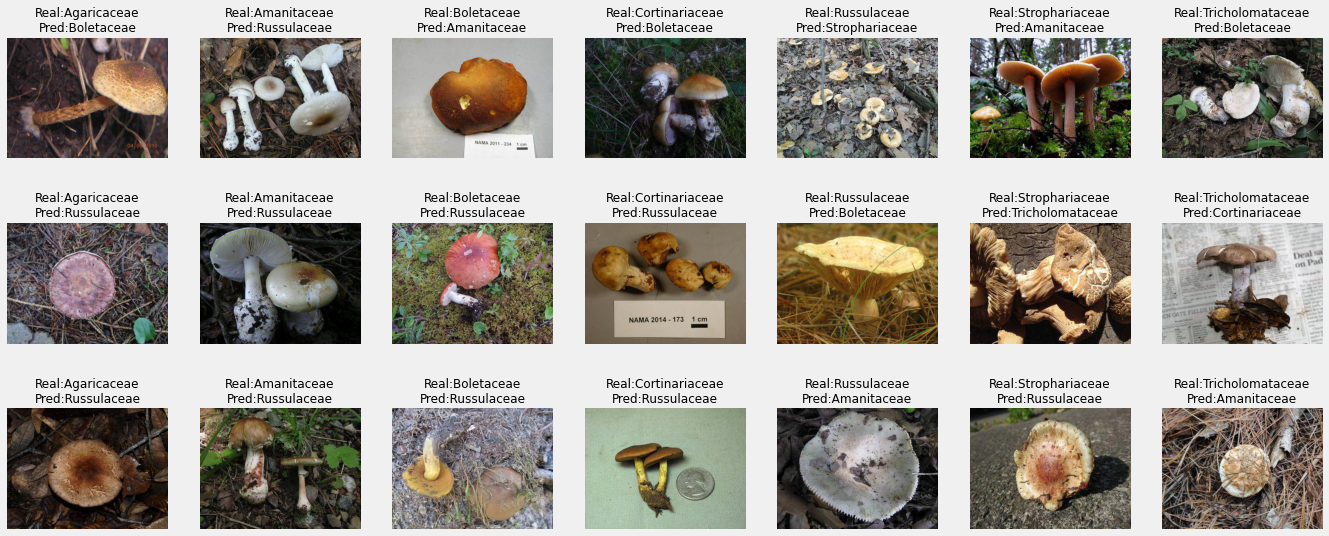

time: 5.28 s (started: 2022-02-03 16:00:59 +01:00)


In [158]:
fig,axs=plt.subplots(3,7,figsize=(21,9))
for col in range(7):
    if col==0:
        row=0
        for i in np.random.choice(error_indexes_class0,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==1:
        row=0
        for i in np.random.choice(error_indexes_class1,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==2:
        row=0
        for i in np.random.choice(error_indexes_class2,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==3:
        row=0
        for i in np.random.choice(error_indexes_class3,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==4:
        row=0
        for i in np.random.choice(error_indexes_class4,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==5:
        row=0
        for i in np.random.choice(error_indexes_class5,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==6:
        row=0
        for i in np.random.choice(error_indexes_class6,size=3):
            batch=i//128
            indice=i%128
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
fig.savefig(root_dir +'Deep_learning/220203_15H13_model6/MobileNetV3Small_(240, 320)_7families_all_images_errors y_pred examples.jpeg' );

Inteprétation du graphique ci-dessus:
- 1 colone par famille
- 3 photos par famille: choisies aléatoirement mais parmi les mauvaises prédictions afin de visualiser les erreurs
- sur chaque photo on affiche la famille réelle (les photos sont donc dans les bonnes colonnes) ainsi que la famille prédite par le modèle
Dans notre cas j'affiche les résultats du model6 càd:
- MobileNetV3Small entrainé sur 64% de la totalité des images, validé sur 16% des images et testé sur 20% des images
-Rappel: 35783 images au total; 22905=training, 5722=validation, 7156=test


Inteprétation des résultats:
- on voit qu'il est très difficile pour un amateur de reconnaitre la famille d'un champignon (dfférentes formes et couleurs)
- et pour le modèle il y a aussi des éléments pertubarteurs sur les images (différents angles de prise de vue, un ou plusieurs chamignons sur la même photo, environnement différents(ex: dans l'herbe, dans des feuilles, sur une table, sur la terre, dans une main, etc.)
- Malgré cela, le dernier modèle a quand même atteint une précision moyenne de 60% (pour comparaison si cela avait été du hasard on aurait 100/7=14%)
- En regardant les résultats par famille, on peut voir que certaines familles sont plus faciles à prédire que d'autres: (voir tableau ci_dessous)
    - famille "Boletaceae": précision de 73%
    - famille "Russulaceae": précison de 51% (explication potentielle: peut être plus de variétés)

In [195]:
report_model6_res=report_model6.copy() #copy to not modify the original report

#change the key names into strings
family_names_dict=family_names.to_dict()
family_names_dict['0.0']=family_names_dict.pop(0)
family_names_dict['1.0']=family_names_dict.pop(1)
family_names_dict['2.0']=family_names_dict.pop(2)
family_names_dict['3.0']=family_names_dict.pop(3)
family_names_dict['4.0']=family_names_dict.pop(4)
family_names_dict['5.0']=family_names_dict.pop(5)
family_names_dict['6.0']=family_names_dict.pop(6)

#change the class numbers into the family names
report_model6_res=report_model6_res.rename({'Unnamed: 0': 'param'},axis=1)
report_model6_res['param'].replace(family_names_dict,inplace=True)
report_model6_res

param  precision    recall  f1-score      support
0       Agaricaceae   0.679198  0.516683  0.586898  1049.000000
1       Amanitaceae   0.581028  0.770440  0.662461   954.000000
2        Boletaceae   0.726027  0.743399  0.734611  1212.000000
3    Cortinariaceae   0.573718  0.433939  0.494134   825.000000
4       Russulaceae   0.513714  0.734477  0.604573  1224.000000
5    Strophariaceae   0.632504  0.480534  0.546144   899.000000
6  Tricholomataceae   0.533333  0.426989  0.474273   993.000000
7          accuracy   0.599637  0.599637  0.599637     0.599637
8         macro avg   0.605646  0.586637  0.586156  7156.000000
9      weighted avg   0.607469  0.599637  0.593570  7156.000000

time: 0 ns (started: 2022-02-03 16:53:49 +01:00)
